# Project ADA - Where to eat in Chicago?
## Group prADA

### Description

As part of this project, we intend to establish an interactive map allowing us to know where to eat in Chicago. The idea consists of orienting tourists as much as locals, in order to help them find the option that suits them best restaurant-wise. 

Initially, three main criterias were to be taken into account namely: 
- Sanitary information - Based on the results of the Chicago Food Inspections, we want to establish distinctions between food-establishments that conform to the required cleanliness norms and those that do not. 
- Safeness of the surroundings - Based on the crime records, the purpose is to try and sense whether the close neighborhood is quite safe or if it rather witnesses a high criminality rate and major misconducts. In this perspective, the goal is to help individuals and groups  who happen to be unfamiliar with the area, being aware of eventual security issues. 
- Reputation - A proposal was to conduct a sentiment analysis on online comments, reflecting the public's previous experiences with some specific food-establishments: positive or negative feedback on the food quality, menu variety, pricing and so on. However, due to technical and legal limitations linked to the non-availability of the relevant information, this selected criteria will be replaced by an analysis of the violations. Also resorting to NLP tools, it would be interesting to further understand the violations reported in the Chicago Food Inspections dataset, since they can refer to various distinct issues.


### 1. Getting a sense of the dataset - Chicagoan health food inspections 

In [125]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import math

from requests import get
from bs4 import BeautifulSoup

In [126]:
import seaborn as sns
import folium
from folium import plugins
import datetime
import geopy
from geopy.geocoders import Nominatim 

In [127]:
fi_df = pd.read_csv('./Data/food-inspections.csv', sep = ',', header = 0, names = ['inspection id', 'restaurant name DBA', 'restaurant name AKA', 'license numer','facility type','risk','address','city','state','zip','inspection date','inspection type','result','violations','latitude','longitude','location','historical','zip codes','commun. areas','census tr.','wards'])

In [128]:
fi_df.head()

inspection id                     restaurant name DBA  \
0        2321132                  HOST INTERNATIONAL INC   
1        2321127                               STARBUCKS   
2        2321168                           DUNKIN DONUTS   
3        2321165                               LA HUMITA   
4        2321129  MING BRICKYARD SUPER CHINA BUFFET INC.   

                restaurant name AKA  license numer facility type  \
0  VIENNA BEEF/PIZZERIA UNO (T1 C6)        34222.0    Restaurant   
1             STARBUCKS  (T1  C-07)      2583234.0    Restaurant   
2                     DUNKIN DONUTS        15623.0    Restaurant   
3                         LA HUMITA      1622351.0    Restaurant   
4                SUPER CHINA BUFFET      1490057.0    Restaurant   

              risk                   address     city state      zip  ...  \
0  Risk 2 (Medium)        11601 W TOUHY AVE   CHICAGO    IL  60666.0  ...   
1  Risk 2 (Medium)        11601 W TOUHY AVE   CHICAGO    IL  60666.0  ...   
2  Risk 2 (Medium)       5200 N LINCOLN AVE   CHICAGO    IL  60625.0  ...   
3    Risk 1 (High)        3466 N PULASKI RD   CHICAGO    IL  60641.0  ...   
4    Risk 1 (High)  2650 N NARRAGANSETT AVE   CHICAGO    IL  60639.0  ...   

     result                                         violations   latitude  \
0      Pass                                                NaN  42.008536   
1      Pass                                                NaN  42.008536   
2      Pass                                                NaN  41.975913   
3  No Entry                                                NaN  41.944678   
4      Pass  55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...  41.928847   

   longitude                                           location  historical  \
0 -87.914428  {'longitude': '42.008536400868735', 'latitude'...         NaN   
1 -87.914428  {'longitude': '42.008536400868735', 'latitude'...         NaN   
2 -87.692494  {'longitude': '41.97591289899352', 'latitude':...         NaN   
3 -87.727496  {'longitude': '41.94467795956372', 'latitude':...         NaN   
4 -87.785781  {'longitude': '41.928847223323764', 'latitude'...         NaN   

  zip codes  commun. areas  census tr.  wards  
0       NaN            NaN         NaN    NaN  
1       NaN            NaN         NaN    NaN  
2       NaN            NaN         NaN    NaN  
3       NaN            NaN         NaN    NaN  
4       NaN            NaN         NaN    NaN  

[5 rows x 22 columns]

## CLEANING, UNDERSTANDING THE DATASET

First, we need to check which columns are usable, a preview on the file hints that some columns might be completely empty as it is the case for the following:

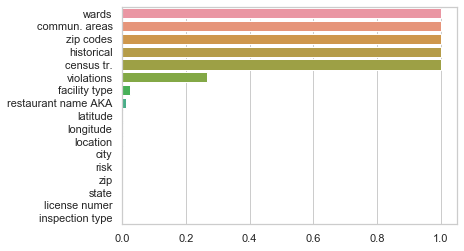

In [129]:
missg_val = fi_df.isnull().sum().sort_values(ascending = False)
missg_val = missg_val[missg_val > 0] / fi_df.shape[0]
sns.barplot(x = missg_val, y = missg_val.index)

We can clearly observe that some columns are full of null values. So we can remove those columns as a first step for cleaning the dataset.

In [130]:
fi_df=fi_df.drop(columns=['historical','zip codes','commun. areas','census tr.','wards'])
fi_df.head(10)

inspection id                     restaurant name DBA  \
0        2321132                  HOST INTERNATIONAL INC   
1        2321127                               STARBUCKS   
2        2321168                           DUNKIN DONUTS   
3        2321165                               LA HUMITA   
4        2321129  MING BRICKYARD SUPER CHINA BUFFET INC.   
5        2321196                     SODEXO AMERICA, LLC   
6        2321148    WILLIAM G. HIBBARD ELEMENTARY SCHOOL   
7        2321187                      BANG BANG BISCUITS   
8        2321166                                  SUBWAY   
9        2321116               Scammon Elementary School   

                          restaurant name AKA  license numer facility type  \
0            VIENNA BEEF/PIZZERIA UNO (T1 C6)        34222.0    Restaurant   
1                       STARBUCKS  (T1  C-07)      2583234.0    Restaurant   
2                               DUNKIN DONUTS        15623.0    Restaurant   
3                                   LA HUMITA      1622351.0    Restaurant   
4                          SUPER CHINA BUFFET      1490057.0    Restaurant   
5  UNITED EMPLOYEE CAFETERIA (T1-C MID LEVEL)      2560546.0    Restaurant   
6         WILLIAM G HIBBARD ELEMENTARY SCHOOL        23801.0        School   
7                          BANG BANG BISCUITS      2458777.0    Restaurant   
8                                      SUBWAY      2529116.0    Restaurant   
9                   Scammon Elementary School        25241.0        School   

              risk                    address     city state      zip  \
0  Risk 2 (Medium)         11601 W TOUHY AVE   CHICAGO    IL  60666.0   
1  Risk 2 (Medium)         11601 W TOUHY AVE   CHICAGO    IL  60666.0   
2  Risk 2 (Medium)        5200 N LINCOLN AVE   CHICAGO    IL  60625.0   
3    Risk 1 (High)         3466 N PULASKI RD   CHICAGO    IL  60641.0   
4    Risk 1 (High)   2650 N NARRAGANSETT AVE   CHICAGO    IL  60639.0   
5    Risk 1 (High)         11601 W TOUHY AVE   CHICAGO    IL  60666.0   
6    Risk 1 (High)         3244 W Ainslie ST   CHICAGO    IL  60625.0   
7    Risk 1 (High)          4947 N DAMEN AVE   CHICAGO    IL  60625.0   
8    Risk 1 (High)   2620 N NARRAGANSETT AVE   CHICAGO    IL  60639.0   
9    Risk 1 (High)  4201 W Henderson (3332N)   CHICAGO    IL  60641.0   

           inspection date          inspection type              result  \
0  2019-11-06T00:00:00.000  Complaint Re-Inspection                Pass   
1  2019-11-06T00:00:00.000  Complaint Re-Inspection                Pass   
2  2019-11-06T00:00:00.000  Complaint Re-Inspection                Pass   
3  2019-11-06T00:00:00.000                  Canvass            No Entry   
4  2019-11-06T00:00:00.000                Complaint                Pass   
5  2019-11-06T00:00:00.000                  Canvass                Pass   
6  2019-11-06T00:00:00.000                  Canvass  Pass w/ Conditions   
7  2019-11-06T00:00:00.000                  Canvass  Pass w/ Conditions   
8  2019-11-06T00:00:00.000                  Canvass                Fail   
9  2019-11-06T00:00:00.000                  Canvass                Fail   

                                          violations   latitude  longitude  \
0                                                NaN  42.008536 -87.914428   
1                                                NaN  42.008536 -87.914428   
2                                                NaN  41.975913 -87.692494   
3                                                NaN  41.944678 -87.727496   
4  55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...  41.928847 -87.785781   
5  47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...  42.008536 -87.914428   
6  10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...  41.970363 -87.710362   
7  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.971969 -87.679136   
8  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...  41.927995 -87.785752   
9  10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...  41.941649 -87.73222

Our research focuses on the city Chicago, our dataset however contains numerous other locations which we have to discard.

In [131]:
fi_df['city'].unique()

array(['CHICAGO', nan, 'chicago', 'Chicago', 'GRIFFITH', 'NEW YORK',
       'SCHAUMBURG', 'ELMHURST', 'NEW HOLSTEIN', 'ALGONQUIN', 'CCHICAGO',
       'NILES NILES', 'EVANSTON', 'CHICAGO.', 'CHESTNUT STREET',
       'LANSING', 'CHICAGOCHICAGO', 'WADSWORTH', 'WILMETTE', 'WHEATON',
       'CHICAGOHICAGO', 'ROSEMONT', 'CHicago', 'CALUMET CITY',
       'PLAINFIELD', 'HIGHLAND PARK', 'PALOS PARK', 'ELK GROVE VILLAGE',
       'CICERO', 'BRIDGEVIEW', 'OAK PARK', 'MAYWOOD', 'LAKE BLUFF',
       '312CHICAGO', 'SCHILLER PARK', 'SKOKIE', 'BEDFORD PARK',
       'BANNOCKBURNDEERFIELD', 'CHCICAGO', 'BLOOMINGDALE', 'Norridge',
       'CHARLES A HAYES', 'CHCHICAGO', 'CHICAGOI', 'SUMMIT',
       'OOLYMPIA FIELDS', 'WESTMONT', 'CHICAGO HEIGHTS', 'JUSTICE',
       'TINLEY PARK', 'LOMBARD', 'EAST HAZEL CREST', 'COUNTRY CLUB HILLS',
       'STREAMWOOD', 'BOLINGBROOK', 'INACTIVE', 'BERWYN', 'BURNHAM',
       'DES PLAINES', 'LAKE ZURICH', 'OLYMPIA FIELDS', 'alsip',
       'OAK LAWN', 'BLUE ISLAND', 'GLENCOE',

It seems that many suburban areas are referenced as the city of the restaurant associated to the inspection. However, some of those suburbs are located too far from Chicago. As a consequence we decided to focus excusively on the location referenced in Chicago.

We notice that there are differents cities refered in the dataframe. Furthermore, we notice that the chicago city is not correctly referenced: "CHICAGOCHICAGO","CHICAGO.", etc.
It also seems that some locations are refered as cities. Those locations could be in Chicago.

Some locations aren't part of Chicago. However we are aware that those locations, such as Oak Lawn or Oak Park, are really close to the city. So the question is, should we have to keep it or not...

In [132]:
def isChicago(x):
    if re.search('.*CHICAGO.*', x):
        return True
    return False

print('the location referenced in chicago represents {0:.3f} % of the dataset'.format(fi_df[fi_df['city'].apply(lambda x: isChicago(str(x)))].shape[0]/fi_df.shape[0]))

the location referenced in chicago represents 0.996 % of the dataset


This ratio shows that removing the other rows referenced in other location won't impact the integrity of the dataset.

In [133]:
fi_df = fi_df[fi_df['city'].apply(lambda x: isChicago(str(x)))]
fi_df['city'].unique()

array(['CHICAGO', 'CCHICAGO', 'CHICAGO.', 'CHICAGOCHICAGO',
       'CHICAGOHICAGO', '312CHICAGO', 'CHCHICAGO', 'CHICAGOI',
       'CHICAGO HEIGHTS'], dtype=object)

Now that we have all restaurants from the city Chicago, we can now drop this column

In [134]:
fi_df.drop(columns=['city'], inplace = True)

### Removing NaN/Null values

Let's observe the columns that still have nan values

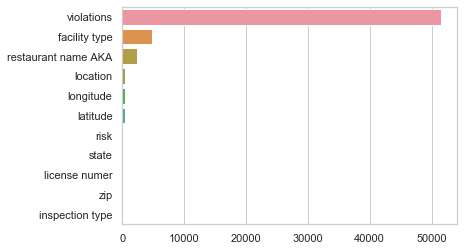

In [135]:
missg_val = fi_df.isnull().sum().sort_values(ascending = False)
missg_val = missg_val[missg_val > 0]
sns.barplot(x = missg_val, y = missg_val.index)

we observe that many columns still have null/nan values. Let's study each one of them

Concerning the violations, we won't be able to replace the missing values. Indeed those informations comes from the inspections so we can't recover them or create them. However, all restaurants won't necessary cause violations. Indeed, we have to consider that a restaurant that passed the last sanitar control may have succeded because of this. So here it doesn't have to be considered as a missing value. However if the violations aren't reported while the control has not been successfully passed, we would consider that the information is not correctly reported and then delete the corresponding line. 

In [136]:
fi_df = fi_df[((~fi_df['violations'].isna()) & fi_df['violations'].apply(lambda x : x != '')) | fi_df['result'].apply(lambda x : x == 'Pass')]

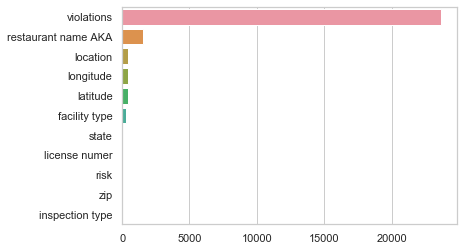

In [137]:
missg_val = fi_df.isnull().sum().sort_values(ascending = False)
missg_val = missg_val[missg_val > 0]
sns.barplot(x = missg_val, y = missg_val.index)

we can see that we almost delete half of the rows that have null values in the violotions column. But we have 20000 rows so more than 10% of the dataframe that passed the control with no violation reported. This shows that it is important not to delete them.

Now, considering the restaurant name AKA

In [138]:
fi_df[['restaurant name DBA','restaurant name AKA']].head()

restaurant name DBA  \
0                  HOST INTERNATIONAL INC   
1                               STARBUCKS   
2                           DUNKIN DONUTS   
4  MING BRICKYARD SUPER CHINA BUFFET INC.   
5                     SODEXO AMERICA, LLC   

                          restaurant name AKA  
0            VIENNA BEEF/PIZZERIA UNO (T1 C6)  
1                       STARBUCKS  (T1  C-07)  
2                               DUNKIN DONUTS  
4                          SUPER CHINA BUFFET  
5  UNITED EMPLOYEE CAFETERIA (T1-C MID LEVEL)

according to the head of the dataframe, we can see that we can recover the AKA name with the DBA name of the restaurant. So we can try actually to merge these two columns by prefering the AKA name.
As we didn't detect any null DBA name, we should fill every missing value in this column processing this way.

In [139]:
fi_df['restaurant name'] = fi_df.apply(lambda row : row['restaurant name AKA'] if not pd.isnull(row['restaurant name AKA']) else row['restaurant name DBA'], axis = 1)
fi_df.drop(columns = ['restaurant name AKA', 'restaurant name DBA'], inplace = True)
fi_df.head()

inspection id  license numer facility type             risk  \
0        2321132        34222.0    Restaurant  Risk 2 (Medium)   
1        2321127      2583234.0    Restaurant  Risk 2 (Medium)   
2        2321168        15623.0    Restaurant  Risk 2 (Medium)   
4        2321129      1490057.0    Restaurant    Risk 1 (High)   
5        2321196      2560546.0    Restaurant    Risk 1 (High)   

                    address state      zip          inspection date  \
0        11601 W TOUHY AVE     IL  60666.0  2019-11-06T00:00:00.000   
1        11601 W TOUHY AVE     IL  60666.0  2019-11-06T00:00:00.000   
2       5200 N LINCOLN AVE     IL  60625.0  2019-11-06T00:00:00.000   
4  2650 N NARRAGANSETT AVE     IL  60639.0  2019-11-06T00:00:00.000   
5        11601 W TOUHY AVE     IL  60666.0  2019-11-06T00:00:00.000   

           inspection type result  \
0  Complaint Re-Inspection   Pass   
1  Complaint Re-Inspection   Pass   
2  Complaint Re-Inspection   Pass   
4                Complaint   Pass   
5                  Canvass   Pass   

                                          violations   latitude  longitude  \
0                                                NaN  42.008536 -87.914428   
1                                                NaN  42.008536 -87.914428   
2                                                NaN  41.975913 -87.692494   
4  55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...  41.928847 -87.785781   
5  47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...  42.008536 -87.914428   

                                            location  \
0  {'longitude': '42.008536400868735', 'latitude'...   
1  {'longitude': '42.008536400868735', 'latitude'...   
2  {'longitude': '41.97591289899352', 'latitude':...   
4  {'longitude': '41.928847223323764', 'latitude'...   
5  {'longitude': '42.008536400868735', 'latitude'...   

                              restaurant name  
0            VIENNA BEEF/PIZZERIA UNO (T1 C6)  
1                       STARBUCKS  (T1  C-07)  
2                               DUNKIN DONUTS  
4                          SUPER CHINA BUFFET  
5  UNITED EMPLOYEE CAFETERIA (T1-C MID LEVEL)

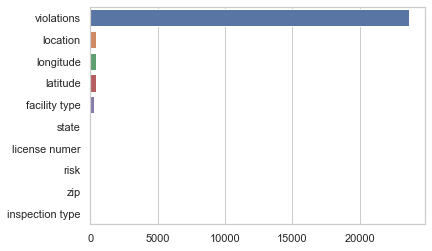

In [140]:
missg_val = fi_df.isnull().sum().sort_values(ascending = False)
missg_val = missg_val[missg_val > 0]
sns.barplot(x = missg_val, y = missg_val.index)

Now we can see that no name is missing

In [141]:
missg_val

violations         23659
location             458
longitude            458
latitude             458
facility type        316
state                 17
license numer         15
risk                  12
zip                    2
inspection type        1
dtype: int64

We observe that there is exactly the same number of missing values for location, longitude and latitude. We also know that the location information is just the merge of the two longitude and latitude information. We found a library that would help us to recover the longitude and latitude information based on the address

However, it seems that there are errors or unprecisions in the address of the restaurants that have unkown location. As a consequence, the geopy library is not powerfull enough to retrieve the location based on those uncorrect addresses. We show an exemple right bellow

In [142]:
fi_df[fi_df['address'] == '2009 S LAFIN ST ']

inspection id  license numer facility type             risk  \
1017        2315463      2578370.0    Restaurant  Risk 2 (Medium)   

               address state      zip          inspection date  \
1017  2009 S LAFIN ST     IL  60608.0  2019-10-08T00:00:00.000   

     inspection type result  \
1017         License   Fail   

                                             violations  latitude  longitude  \
1017  3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...       NaN        NaN   

     location restaurant name  
1017      NaN           VEENO

In this example we can see that the restaurants with this address have nan location/latitude/longitude. Let's try to find this informations with geopy.

In [143]:
geolocator = Nominatim(user_agent = 'project_ADA')

In [144]:
location = geolocator.geocode('2009 S LAFIN ST ')
print(location)

Lafin Street, Bayside Lakes, Palm Bay, Brevard County, Florida, 32908-1206, United States


It finds a result that is actually located in Palm Bay Florida. If we try to precise the city in the address :

In [145]:
location = geolocator.geocode('2009 S LAFIN ST Chicago')
print(location)

None


It doesn't find any location in Chicago. By looking in Google, we noticed that there is an error in the address. If we correct it we obtain a relevent location.

In [146]:
location = geolocator.geocode('2009 S LAFLIN ST Chicago')
print(location)

2009, South Laflin Street, Lower West Side, Chicago, Cook County, Illinois, 60608, United States of America


However those kind of errors or misunderstandings can be correctly automatically. So we abandoned the idea of recovering the location with geopy and decided to remove the rows with unknown location.

In [147]:
fi_df=fi_df.dropna(subset=['latitude', 'longitude', 'location'], how = "any")

We also wants to directly retrieve float values of both longitude and latitude directly from the 'location' column then it would be more convenient when retrieving those data for maps plotting.

In [148]:
def get_location(string):
    groups = re.findall('-*[0-9]+.[0-9]+', string) #look at patterns matching longitude and lattitude formats in strings
    return [groups[0], groups[1]] #return an array containing (lattitude,longitude) couples
                             
fi_df['location'] = fi_df.location.apply(lambda x: get_location(x))

In [149]:
fi_df.head()

inspection id  license numer facility type             risk  \
0        2321132        34222.0    Restaurant  Risk 2 (Medium)   
1        2321127      2583234.0    Restaurant  Risk 2 (Medium)   
2        2321168        15623.0    Restaurant  Risk 2 (Medium)   
4        2321129      1490057.0    Restaurant    Risk 1 (High)   
5        2321196      2560546.0    Restaurant    Risk 1 (High)   

                    address state      zip          inspection date  \
0        11601 W TOUHY AVE     IL  60666.0  2019-11-06T00:00:00.000   
1        11601 W TOUHY AVE     IL  60666.0  2019-11-06T00:00:00.000   
2       5200 N LINCOLN AVE     IL  60625.0  2019-11-06T00:00:00.000   
4  2650 N NARRAGANSETT AVE     IL  60639.0  2019-11-06T00:00:00.000   
5        11601 W TOUHY AVE     IL  60666.0  2019-11-06T00:00:00.000   

           inspection type result  \
0  Complaint Re-Inspection   Pass   
1  Complaint Re-Inspection   Pass   
2  Complaint Re-Inspection   Pass   
4                Complaint   Pass   
5                  Canvass   Pass   

                                          violations   latitude  longitude  \
0                                                NaN  42.008536 -87.914428   
1                                                NaN  42.008536 -87.914428   
2                                                NaN  41.975913 -87.692494   
4  55. PHYSICAL FACILITIES INSTALLED, MAINTAINED ...  41.928847 -87.785781   
5  47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...  42.008536 -87.914428   

                                   location  \
0  [42.008536400868735, -87.91442843927047]   
1  [42.008536400868735, -87.91442843927047]   
2   [41.97591289899352, -87.69249417466321]   
4  [41.928847223323764, -87.78578101920121]   
5  [42.008536400868735, -87.91442843927047]   

                              restaurant name  
0            VIENNA BEEF/PIZZERIA UNO (T1 C6)  
1                       STARBUCKS  (T1  C-07)  
2                               DUNKIN DONUTS  
4                          SUPER CHINA BUFFET  
5  UNITED EMPLOYEE CAFETERIA (T1-C MID LEVEL)

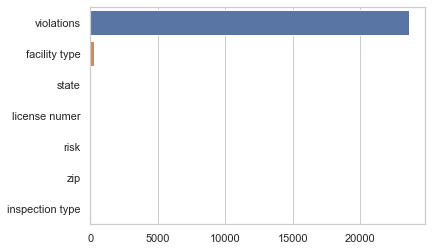

In [150]:
missg_val = fi_df.isnull().sum().sort_values(ascending = False)
missg_val = missg_val[missg_val > 0]
sns.barplot(x = missg_val, y = missg_val.index)

In [151]:
fi_df.dropna(subset = ['risk','facility type', 'license numer', 'inspection type'], how = 'any', inplace = True)

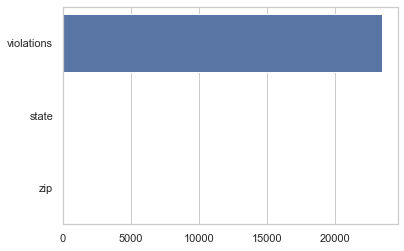

In [154]:
missg_val = fi_df.isnull().sum().sort_values(ascending = False)
missg_val = missg_val[missg_val > 0]
sns.barplot(x = missg_val, y = missg_val.index)

In [155]:
fi_df['state'].unique()

array(['IL', nan], dtype=object)

We see above that only restaurant in Illinois remanes. Having nan values in 'zip' or 'state column won't bother us for the further studies so we don't need to remove those restaurant.  

Now that we don't have nan values that would bother us anymore, the unneeded informations have been mostly removed. However, a column indicates whether or not an inspection has been succesfully passed or not. Many labels in this columns weren't clear. Let's see what labels remain in the dataframe. 

In [156]:
fi_df['result'].unique()

array(['Pass', 'Pass w/ Conditions', 'Fail', 'No Entry', 'Not Ready',
       'Out of Business'], dtype=object)

The 'Out of Business' label indicates clearly that the facility is closed. So it doesn't interest us to have this kind of facililities in the dataframe. 

In [157]:
fi_df = fi_df[fi_df.result.apply(lambda x : x != 'Out of Business')]

### Facility types

First we consider the facility types, we are in the skin of a tourist or any other person looking for a place to eat in Chicago. So the facility types such as churches, schools, hospitals etc. are not taken into consideration.

In [158]:
def get_cv(serie):
    tmp = serie.value_counts()
    return tmp.tolist(), tmp.keys().tolist()

In [159]:
facility_count, facility_key = get_cv(fi_df['facility type'])

In [160]:
def merge_minorities(counts, keys, size):
    labels = []
    m_counts = []
    minorities_count = 0
    percent_ref = 0.01 * size
    for c, l in zip(counts, keys):
        if c < percent_ref:
            minorities_count += c
        else:
            labels.append(l)
            m_counts.append(c)
    labels.append('others')
    m_counts.append(minorities_count)
    return m_counts, labels

In [161]:
counts, labels = merge_minorities(facility_count, facility_key, fi_df.shape[0])

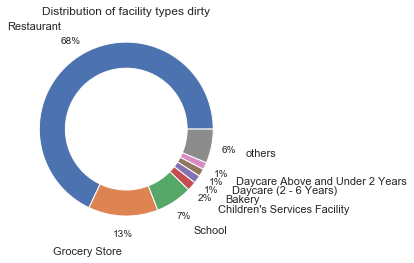

In [162]:
m_circle = plt.Circle((0,0), 0.7, color = "white")
plt.pie(counts, labels = labels, autopct='%1.0f%%', pctdistance=1.2, labeldistance=1.4)
p = plt.gcf()
p.gca().add_artist(m_circle)
plt.title('Distribution of facility types dirty')
plt.show()

We can see that some facilities represented in this dataset is irrelevent for our problematic such as Schools, Children's Services, Daycare... So we want to keep the facilities that target people for buying food at their places. 

In [163]:
#2. drop all values that aren't litterals
fi_df['facility type']=fi_df['facility type'].astype(str)

non_numerical_ft=fi_df['facility type'].apply(lambda f: not f.isdigit())
fi_df=fi_df[non_numerical_ft]

#3. keep only facility types of interest
#discarded_facilities=['care','hospital','church','gas','children','kiosk','store','school','kitchen','facility','wholesale'];
interest=['restaurant','bakery','diner','roof','mobile','bar','diner','breakfast','lounge','grill','tavern', 'store', 'wholesale']
facility_column=fi_df['facility type'].copy().apply(lambda c: c.lower()).apply(lambda c: any( w in c for w in interest))
fi_df=fi_df[facility_column]
fi_df['facility type'] = fi_df['facility type'].apply(lambda c: c.lower())


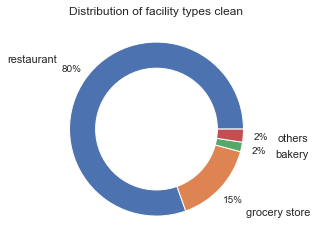

In [164]:
facility_count, facility_key = get_cv(fi_df['facility type'])
counts, labels = merge_minorities(facility_count, facility_key, fi_df.shape[0])
m_circle = plt.Circle((0,0), 0.7, color = "white")
plt.pie(counts, labels = labels, autopct='%1.0f%%', pctdistance=1.2, labeldistance=1.4)
p = plt.gcf()
p.gca().add_artist(m_circle)
plt.title('Distribution of facility types clean')
plt.show()

Now we have kept facilities that seems to correspond to our problematic.

## Analysis

A cleaning process has been done in the last section. We think that it left us a usable dataset at this point. We can now look deeper in the dataset, analyse it.

### Inspections Distribution through time

We are aware that the dataset is oriented on the inpections and not on the restaurants. As we want to study the restaurants we want to make sure that the inspections won't influence the results on the restaurants. 

In [165]:
fi_df['inspection date']=pd.to_datetime(fi_df['inspection date'])

Text(0.5, 1.0, '#inspection per day')

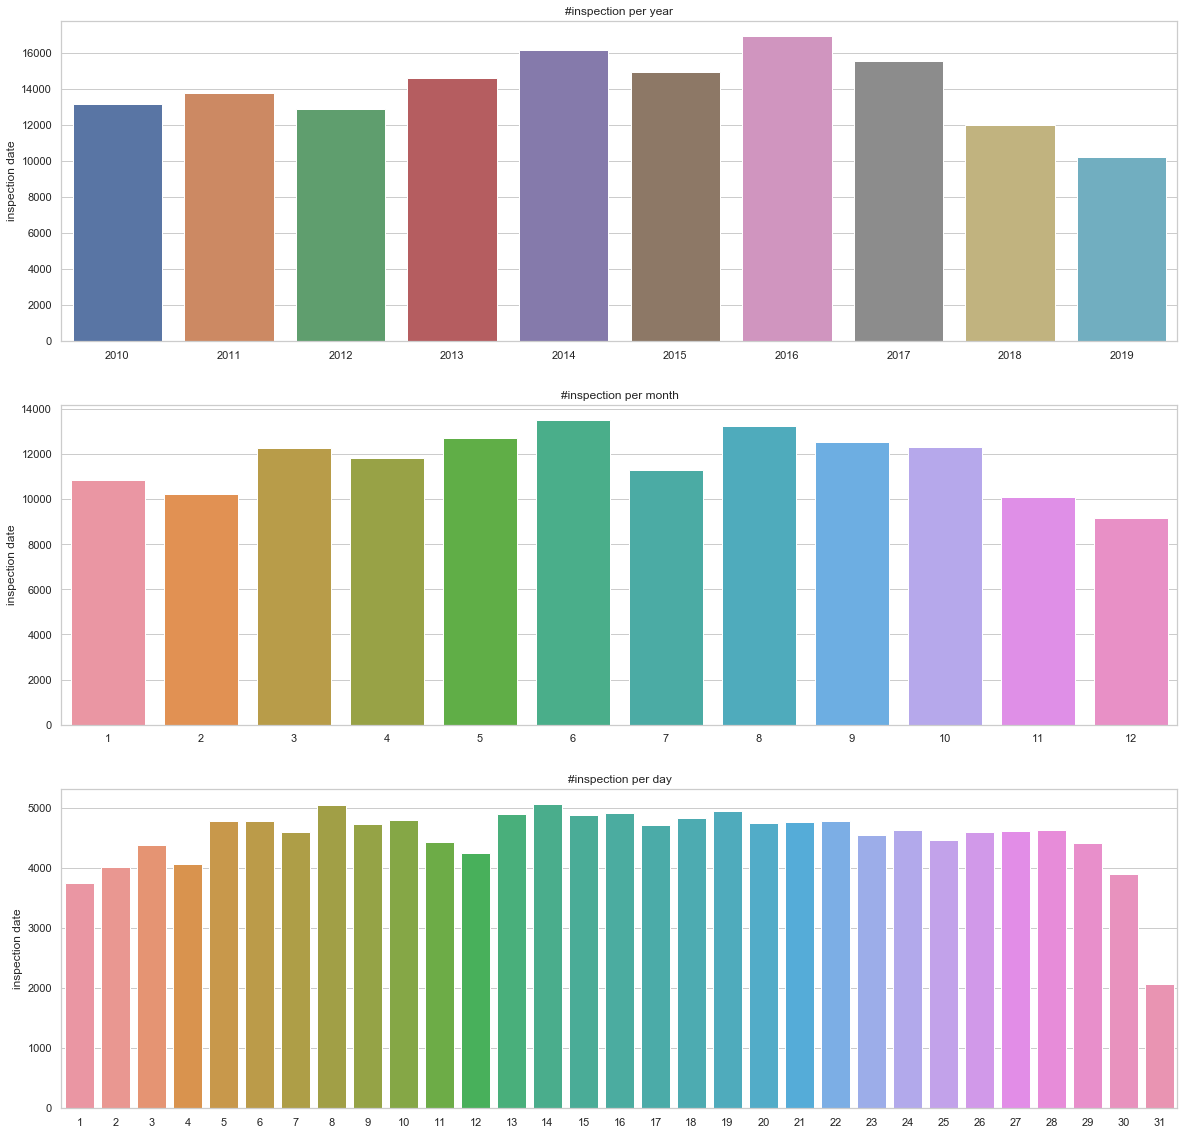

In [168]:
fig,ax=plt.subplots(3,figsize=(20,20))
count_by_y = fi_df['inspection date'].apply(lambda d: d.year).value_counts()
count_by_m = fi_df['inspection date'].apply(lambda d: d.month).value_counts()
count_by_d = fi_df['inspection date'].apply(lambda d: d.day).value_counts()
sns.barplot(x = count_by_y.index, y = count_by_y, ax = ax[0])
ax[0].set_title('#inspection per year')
sns.barplot(x = count_by_m.index, y = count_by_m, ax = ax[1])
ax[1].set_title('#inspection per month')
sns.barplot(x = count_by_d.index, y = count_by_d, ax = ax[2])
ax[2].set_title('#inspection per day')

We observe that the inspections are uniformly distributed by day, month and year. The drop at 2019 is explained by the fact that the year is not over and the drop at day 31 because this day doesn't exist for 6 months. However, the variations in the year distribution can testifies the variation of the number of opened restaurants.

In [169]:
fi_df['year'] =fi_df['inspection date'].apply(lambda d : d.year) #create a year column for further studies

In [170]:
fi_df['month'] = fi_df['inspection date'].apply(lambda d : d.month) #create a month column for further studies

### risk evaluation in restaurant oriented dataset

We remember that the dataset in inspection oriented. Also, the same restaurant can pass many inspections over the years, can fail some of them and pass the others. Also we observed that the same restaurant can have different license numbers.

In [171]:
fi_df[fi_df['restaurant name'] == 'SUBWAY'].groupby('address')['license numer'].agg('count').head()

address
1 E 83RD ST            21
100 W 87TH ST          14
100 W RANDOLPH ST      13
1014 S WESTERN AVE     14
1020 W BELMONT AVE     17
Name: license numer, dtype: int64

It also shows that a name can be shared by many restaurant. A location can also be shared by different brands. As a consequence, we have to find a way to differenciate each restaurant by its location in a single column. 

In [172]:
#merge restaurant name with address to identify the unique restaurant at a place
fi_df['name'] = fi_df.apply(lambda row : row['restaurant name'] + ' ' + row['address'], axis = 1)

#### Focus on the last inspection for each restaurant

We want to study the 'result' of each restaurant. However, this result is not unique as a restaurant can have many inspections. As a consequence, we want to recover the last inspection of each restaurant to define the status of this restaurant.

In [173]:
last_inspections = fi_df.groupby('name')['inspection date'].agg('max')

In [174]:
final = fi_df.merge(pd.DataFrame(last_inspections), left_on='name', right_on='name', suffixes=(' left', ' right'))

In [175]:
final = final[final['inspection date left'] == final['inspection date right']]

In [176]:
results_vc = final['result'].value_counts()
result_count, result_key = get_cv(final['result'])

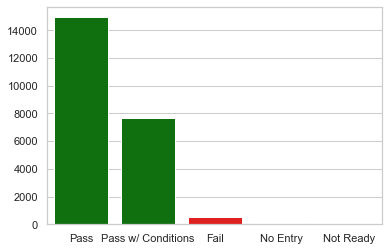

In [177]:
sns.barplot(x = result_key, y = result_count, palette = ['green','green', 'red', 'red', 'red'])

We don't understand what 'Fail', 'No Entry', 'Not Ready' are. But what we are sure is that the inspections that have a 'Pass' or 'Pass w/ Conditions' have the right to sell food and are opened. 

In [178]:
#keep only the restaurant that have passed their last inspection
final_passed = final[final['result'].apply(lambda x : x == 'Pass' or x == 'Pass w/ Conditions')]

We want to analyse the quality of those restaurants. The column that seems to give use the quality of each restaurant is the 'risk', as well as the column 'violation'. So want to prove the following: a restaurant of risk='Risk 1 (high)' transgresses more rules than a restaurant of risk='Risk 3 (low)'. Also we want to analyze the type of violated rules, they should not be the same. Let's see how we can analyze and clean the 'violation' column.


In [179]:

def discard_comment(x):
    if(x!='nan'):
        x=x.strip()
        x=x.split('- Comments:')
        x=x[0].strip().split('.')
        if(len(x)>1):
            return x[1].strip()
        else:
            return x[0]
        
    else:
        return 'No violation'

def discard_violation(x):
    if(x!='nan'):
        x=x.strip()
        x=x.split('- Comments:')
        if(len(x)>1):
            return x[1].strip()
        else:
            return 'No comments'
    else:
        return 'No violation'



We first clean the column itself before moving on to some deeper processing. We add a 'Comment' column obtained from the violations, where we keep the information written in the comments, for later use (if needed). 

In [180]:
fi_df['violations']=fi_df['violations'].astype(str)
fi_df['violations']=fi_df['violations'].apply(lambda v:v.split('|'))

In [181]:
fi_df['comments']=fi_df['violations'].copy().apply(lambda v: [discard_violation(v_i) for v_i in v])
fi_df['comments'].head(10)

0                                        [No violation]
1                                        [No violation]
2                                        [No violation]
4     [CLEAN THE GREASE ON THE WALL BEHIND THE DEEP ...
5     [INSTRUCTED TO REFINISH OR REPLACE CUTTING BOA...
7     [NO EMPLOYEE HEALTH POLICY ON SITE. INSTRUCTED...
8     [OBSERVED NO WRITTEN EMPLOYEE HEALTH POLICY ON...
10                                       [No violation]
13    [OBSERVED NO EMPLOYEE HEALTH POLICY ON THE PRE...
14    [OBSERVED NO EMPLOYE HEALTH POLICY ON PREMISES...
Name: comments, dtype: object

In [182]:
fi_df['violations']=fi_df['violations'].apply(lambda v: [discard_comment(v_i) for v_i in v])


The set of **rules**, groups all the different existing type of violation. 

In [183]:
rules=fi_df['violations'].copy()
rules=rules.apply(lambda v: [discard_comment(v_i) for v_i in v])
rules=np.unique(rules.explode())

In [184]:
rules=pd.Series(rules)
rules.head()

0    * CERTIFIED FOOD MANAGER ON SITE WHEN POTENTIA...
1    * INSPECTION REPORT SUMMARY DISPLAYED AND VISI...
2    ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED A...
3    ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, DESIG...
4    ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, PROPE...
dtype: object

In [185]:
print(rules.to_string())

0      * CERTIFIED FOOD MANAGER ON SITE WHEN POTENTIA...
1      * INSPECTION REPORT SUMMARY DISPLAYED AND VISI...
2      ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED A...
3      ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, DESIG...
4      ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, PROPE...
5      ADEQUATE VENTILATION & LIGHTING; DESIGNATED AR...
6          ALL FOOD EMPLOYEES HAVE FOOD HANDLER TRAINING
7                          ALLERGEN TRAINING AS REQUIRED
8      APPROPRIATE METHOD OF HANDLING OF FOOD (ICE) H...
9                          APPROVED THAWING METHODS USED
10     CITY OF CHICAGO FOOD SERVICE SANITATION CERTIF...
11     CLEAN MULTI-USE UTENSILS AND SINGLE SERVICE AR...
12            COMPLIANCE WITH CLEAN INDOOR AIR ORDINANCE
13     COMPLIANCE WITH VARIANCE/SPECIALIZED PROCESS/H...
14     CONSUMER ADVISORY PROVIDED FOR RAW/UNDERCOOKED...
15     CONTAMINATION PREVENTED DURING FOOD PREPARATIO...
16     DISH MACHINES: PROVIDED WITH ACCURATE THERMOME...
17     DISH WASHING FACILITIES:

There are more than 100 rules (108 in fact), it would be intersting to cluster them into groups and give a weight to each group in order to rank a restaurant based on its violations if existing. With the help of the initial health inspection check list which can be found [here](https://www.chicago.gov/content/dam/city/depts/cdph/food_env/general/Food_Protection/FoodProtectionQuickGuide7272012b.pdf), we can categorize this given set of rules and weigh the categories.To weigh the categories we can count the number of times a violation appears in an inspection with risk 1,2 and 3. We also want to explore the association between the type of violations and the risk. Does each risk have a specific distribution of appearance of violations?

In [186]:

#this dictionary groups all the categories of violations and the index of the corresponding violation, it was done manually.
#it won't be used for this milestone, more to come in milestone 3..
categories={'Hand washing sinks for employees':[2,7,81,95,104],'Time and temperature':[6,18,21,23,25,27,29,33,45,53,55,58,68,16],
            'Contamination protection and vermin':[9,11,13,18,37,61,63,66,79,84,101,106],'Potable water':[49,85,86,102,107],
            'Waste':[3,20,24,69,87,89],'Certificates':[22,42,92,93,98],
            'General food safety requirements':[1,17,5,8,14,15,34,38,72,96,103],'Storage':[12,35,70,73,74,78],
            'Equipment/linens/ustensils':[28,30,32,48,52,64,76,78,105],'Physical facilities':[36,39,40,54,56,57,60,62,80,82,88,91,99,100],
           'Employees':[0,26,44,67,72,75,83],'Improvements':[10,42,94,60]}


In [187]:
rules_df=pd.DataFrame(rules,columns=['Rules'])
rules_categories=pd.Series([])

for c,indexes in categories.items():
    for ind in indexes:
        rules_categories[ind]=c   
rules_df['Categories']=rules_categories

Let's start to explore the association of risk and violation. We compute the mean number of violations per restaurant and group it by risk, in order to find the overall average of number of violations per risk-type.

In [188]:
rv_df=pd.concat([fi_df['violations'].copy(),fi_df['risk'].copy()],axis=1)


In [189]:
rv_df_mean_vc=rv_df.copy()
#convert to array 
rv_df_mean_vc['violations']=rv_df_mean_vc['violations'].apply(lambda l_v: len(l_v))

rv_df_mean_vc.groupby('risk').agg('mean')

violations
risk                       
Risk 1 (High)      4.295905
Risk 2 (Medium)    3.636676
Risk 3 (Low)       3.014644

Here, as we would expect we can see the lower the risk the less violations we have in general. So a restaurant that has high risk in general transgresses more rules thant a low-risk one. Now let's go further, in our exploration, can we observe that low risk restaurants also have minor violations?

In [190]:
rv_df=rv_df.explode('violations')

In [191]:
rv_count=rv_df.groupby(['risk'])['violations'].value_counts()

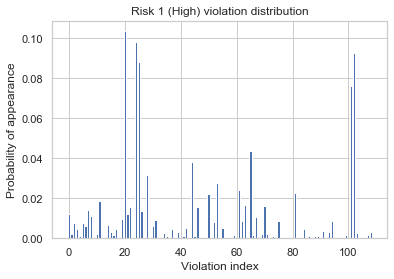

In [192]:
rv_r1=rv_count['Risk 1 (High)'].sort_index()
total=rv_r1.sum()
ratio_r1=rv_r1/total

plt.bar(x= range(len(rv_r1)), height= ratio_r1)
plt.title('Risk 1 (High) violation distribution')
plt.xlabel('Violation index')
plt.ylabel('Probability of appearance')
plt.show()

In [193]:
ratio_r1.idxmax()

'FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED'

In [194]:
ratio_r1[43:45]

violations
INSIDE CONTAINERS OR RECEPTACLES: ADEQUATE NUMBER, PROPERLY COVERED AND INSECT/RODENT PROOF    0.000086
LIGHTING: REQUIRED MINIMUM FOOT-CANDLES OF LIGHT PROVIDED, FIXTURES SHIELDED                   0.038000
Name: violations, dtype: float64

In [195]:
ratio_r1[64:66]

violations
POTENTIALLY HAZARDOUS FOOD PROPERLY THAWED                                                       0.000227
PREMISES MAINTAINED FREE OF LITTER, UNNECESSARY ARTICLES, CLEANING  EQUIPMENT PROPERLY STORED    0.043632
Name: violations, dtype: float64

In [196]:
ratio_r1[101:104]

violations
VENTILATION: ROOMS AND EQUIPMENT VENTED AS REQUIRED: PLUMBING: INSTALLED AND MAINTAINED                                 0.076266
WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS    0.092499
WAREWASHING FACILITIES: INSTALLED, MAINTAINED & USED; TEST STRIPS                                                       0.002603
Name: violations, dtype: float64

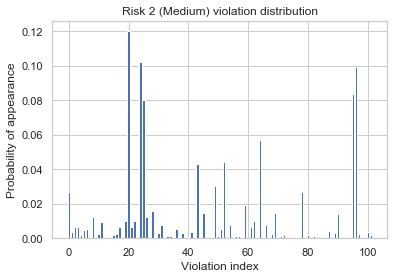

In [197]:
rv_r2=rv_count['Risk 2 (Medium)'].sort_index()
total=rv_r2.sum()
ratio_r2=rv_r2/total

plt.bar(x= range(len(rv_r2)), height= ratio_r2)
plt.title('Risk 2 (Medium) violation distribution')
plt.xlabel('Violation index')
plt.ylabel('Probability of appearance')
plt.show()

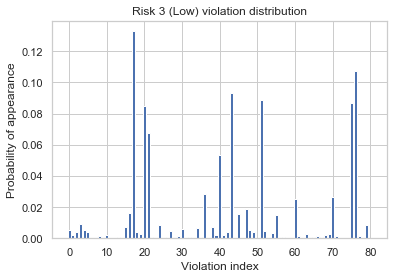

In [198]:
rv_r3=rv_count['Risk 3 (Low)'].sort_index()
total=rv_r3.sum()
ratio_r3=rv_r3/total

plt.bar(x= range(len(rv_r3)), height= ratio_r3)
plt.title('Risk 3 (Low) violation distribution')
plt.xlabel('Violation index')
plt.ylabel('Probability of appearance')
plt.show()

In [199]:
ratio_r3.idxmax()

'FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED'

From the obtained result we see that the most violated rule for the 3 type of risk is the same and is :'FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED'. The categories of violations that appear the most among the distributions are 'physical facilites' and proper equipment use (i.e category equipment/ustensils/linens). We could imagine that on inspection facilities focus more on heavy violations such as food contamination, general food requirements, correct licenses etc. Facility issues may also need more investement and are time consuming, so they are more often forgotten. So we do not observe any heavy difference of distribution in the type of violations among the risk types (especially between 1 and 2), however we can observe that the lower the type the less violations types we have, which makes sense.

In [200]:
fi_df[fi_df['address'] == '6237 S HALSTED PKWY ']

Empty DataFrame
Columns: [inspection id, license numer, facility type, risk, address, state, zip, inspection date, inspection type, result, violations, latitude, longitude, location, restaurant name, year, month, name, comments]
Index: []

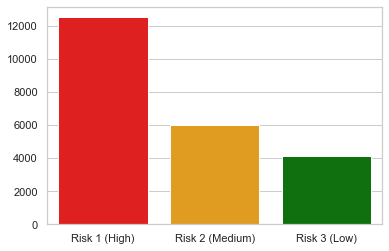

In [201]:
risk_count, risk_key = get_cv(final_passed['risk'])
sns.barplot(risk_key, risk_count, palette = ['red', 'orange', 'green'])

Now let's start our first visualisation of the chicagoean restaurant map, for this we will be using Folium introduced in the course. Let's start with a very simple one: the restaurants that passed the inspection in 2019.

In [202]:
fi_df['location'][1]

['42.008536400868735', '-87.91442843927047']

In [203]:
import folium

loc=fi_df['location'][1]
risk1_m= folium.Map(location=loc)
risk2_m= folium.Map(location=loc)
risk3_m= folium.Map(location=loc)


In [204]:
final_passed_2019 = final_passed[final_passed['year'] == 2019]

In [205]:
risk1_final_passed = final_passed_2019[final_passed_2019['risk'] == 'Risk 1 (High)']
risk2_final_passed = final_passed_2019[final_passed_2019['risk'] == 'Risk 2 (Medium)']
risk3_final_passed = final_passed_2019[final_passed_2019['risk'] == 'Risk 3 (Low)']

In [206]:
risk1_tronc= risk1_final_passed[['latitude', 'longitude', 'restaurant name']].sample(frac = 1).values[:2000]
risk1_dm=plugins.MarkerCluster().add_to(risk1_m)
for marker in risk1_tronc:
    folium.Marker(location=marker[:-1],icon=None,popup=marker[-1]).add_to(risk1_dm)
risk1_m.add_child(risk1_dm)

risk1_m

In [207]:
#risk1_m.save('maps/risk1_markers.html')

You can find the map [here](maps/risk1_markers.html).

In [208]:
risk2_tronc= risk2_final_passed[['latitude', 'longitude', 'restaurant name']].sample(frac = 1).values[:2000]
risk2_dm=plugins.MarkerCluster().add_to(risk2_m)
for marker in risk2_tronc:
    folium.Marker(location=marker[:-1],icon=None,popup=marker[-1]).add_to(risk2_dm)
risk2_m.add_child(risk2_dm)

risk2_m

In [209]:

#risk2_m.save('maps/risk2_markers.html')


You can find the map [here](maps/risk2_markers.html).


In [210]:
risk3_tronc= risk3_final_passed[['latitude', 'longitude', 'restaurant name']].sample(frac = 1).values[:2000]
risk3_dm=plugins.MarkerCluster().add_to(risk3_m)
for marker in risk3_tronc:
    folium.Marker(location=marker[:-1],icon=None,popup=marker[-1]).add_to(risk3_dm)
risk3_m.add_child(risk3_dm)

risk3_m

In [211]:
#risk3_m.save('maps/risk3_markers.html')


You can find the map [here](maps/risk3_markers.html).

In [212]:
import folium

loc=fi_df['location'][1]
risk1_m= folium.Map(location=loc)
risk2_m= folium.Map(location=loc)
risk3_m= folium.Map(location=loc)


In [213]:
risk1_m.add_child(plugins.HeatMap(risk1_final_passed[['latitude', 'longitude']].values,
                            radius=5,
                            max_zoom=1,
                            blur=10, 
                            max_val=3.0))
risk1_m

In [214]:

#risk1_m.save('maps/risk1_heatmap.html')


You can find the map [here](maps/risk1_heatmap.html).

In [215]:
risk2_m.add_child(plugins.HeatMap(risk2_final_passed[['latitude', 'longitude']].values,
                            radius=5,
                            max_zoom=1,
                            blur=10, 
                            max_val=3.0))
risk2_m

In [216]:

#risk2_m.save('maps/risk2_heatmap.html')


You can find the map [here](maps/risk2_heatmap.html).

In [217]:
risk3_m.add_child(plugins.HeatMap(risk3_final_passed[['latitude', 'longitude']].values,
                            radius=5,
                            max_zoom=1,
                            blur=10, 
                            max_val=3.0))
risk3_m

In [218]:

#risk3_m.save('maps/risk3_heatmap.html')

You can find the map [here](maps/risk3_heatmap.html).

2000 markers don't fit into a map, need an alternative

In [219]:
years = fi_df[fi_df['result'].apply(lambda x : x=='Pass' or x == 'Pass w/ Conditions')]

In [220]:
years.shape[0]

110450

In [221]:
test = years.merge(years.groupby(['year', 'name'])['inspection date'].agg('max'), left_on='name', right_on='name', suffixes=(' left', ' right'))

In [222]:
all_y_passed = test[test['inspection date left'] == test['inspection date right']]

In [223]:
risks_vc = all_y_passed.groupby('risk')['year'].value_counts()

In [224]:
total_risks_vc = all_y_passed['year'].value_counts()

In [225]:
total_risks_vc

2016    9731
2013    9647
2015    9602
2014    9549
2017    9322
2012    8243
2011    8150
2010    7884
2018    7622
2019    6932
Name: year, dtype: int64

In [226]:
ratio_risk_1 = risks_vc['Risk 1 (High)'] / total_risks_vc[risks_vc['Risk 1 (High)'].index]
ratio_risk_2 = risks_vc['Risk 2 (Medium)'] / total_risks_vc[risks_vc['Risk 2 (Medium)'].index]
ratio_risk_3 = risks_vc['Risk 3 (Low)'] / total_risks_vc[risks_vc['Risk 3 (Low)'].index]

Text(0.5, 1.0, '#restaurants per year per risk type')

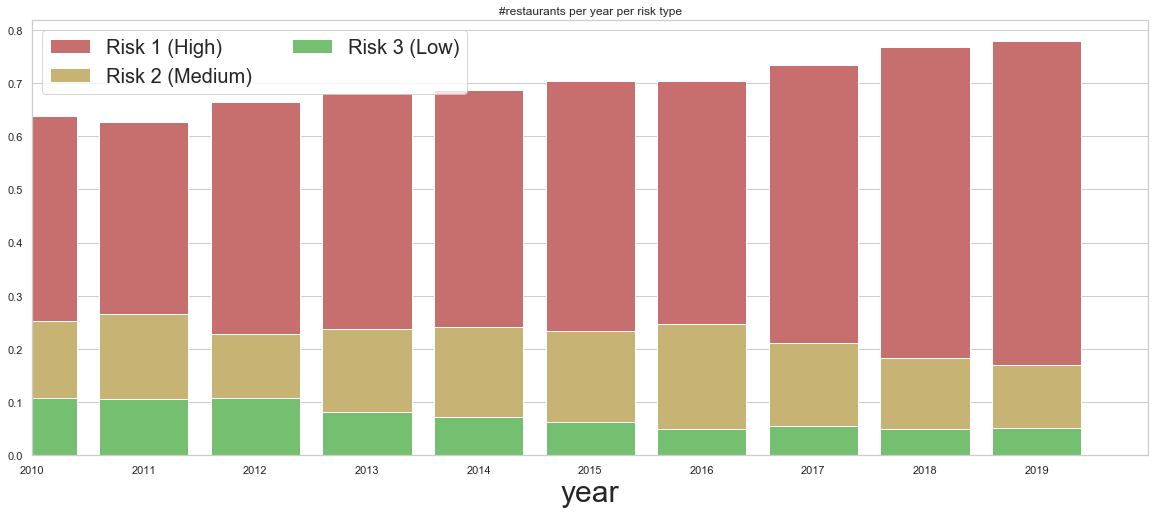

In [233]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(20, 8))

sns.set_color_codes("muted")

sns.barplot(x= ratio_risk_1.index, y= ratio_risk_1,
            label="Risk 1 (High)", color="r")

sns.barplot(x = ratio_risk_2.index, y = ratio_risk_2,
            label='Risk 2 (Medium)', color="y")

sns.barplot(x = ratio_risk_3.index, y = ratio_risk_3,
            label='Risk 3 (Low)', color="g")

ax.legend(ncol=2, loc="upper left", frameon=True, fontsize = 20)
ax.set(xlim=(0, 10), ylabel="")
ax.set_xlabel(xlabel="year", fontsize = 30)
ax.set_title('#restaurants per year per risk type')

In [228]:
fi_df[fi_df['result'] == 'Fail']['risk'].value_counts()

Risk 1 (High)      20352
Risk 2 (Medium)     6344
Risk 3 (Low)        2583
Name: risk, dtype: int64

In [229]:
risk_insp = fi_df.groupby('name')['risk'].value_counts()

In [230]:
risk_insp = risk_insp.groupby('risk').agg('mean')

Text(0.5, 1, '#inspection per Restaurant w.r.t risk')

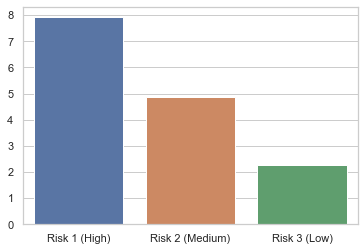

In [234]:
sns.barplot(x=risk_insp.keys().tolist(), y=risk_insp.tolist())
ax.set_title('#inspection per Restaurant w.r.t risk')




# 2. The crime data set - Analysis and cleaning

### Crimes - 2001 to present


In this part, we are going to focus on the Safeness of the surrounding area when choosing a restaurant. According to Wikipedia : " The city's overall crime rate, especially the violent crime rate, is higher than the US average". Therefore, safeness is indeed important. Here, we are going to use the Chicago Police department crime dataset, that is available here : https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2/data

In this notebook, we will do some operations on the dataset, yet it won't consist of the final version that will be used in the rest of the project. In fact, we still have to go into further discussions in order to define how to properly select/modify the features. 

Please also note that for now this part is independent from the others and no comparaison will be done in this milestone.

Let's now load the crime records dataset, according to its actual structure:

In [232]:
crimes_df = pd.read_csv('crime.csv', sep = ',',  dtype={'ID': int, 'Case Number': str, 'Primary Type': str, 'Description': str, 'Location Description': str, 'Arrest':bool, 'Domestic':bool, 'Community area':int, 'X Coordinate': float, 'Y Coordinate':float, 'Year': int, \
                              'Updated on': object, 'Latitude':float, 'Longitude': float,'Location':object})

FileNotFoundError: [Errno 2] File b'crime.csv' does not exist: b'crime.csv'

In [ ]:
crimes_df.head()

According to the chicago data portal here is the description of each features :

- ID : Unique identifier for the record.
- Case Number : The Chicago Police Department RD Number (Records Division Number), which is unique to the incident.
- Cate : Date when the incident occurred. this is sometimes a best estimate.
- Clock : The partially redacted address where the incident occurred, placing it on the same block as the actual address.
- iucr : The Illinois Unifrom Crime Reporting code. This is directly linked to the Primary Type and Description. See the list of IUCR codes at https://data.cityofchicago.org/d/c7ck-438e.
- Primary Type : The primary description of the IUCR code.
- Description : The secondary description of the IUCR code, a subcategory of the primary description.
- Location Description : Description of the location where the incident occurred.
- Arrest : Indicates whether an arrest was made.
- Domestic : Indicates whether the incident was domestic-related as defined by the Illinois Domestic Violence Act.
- Beat : Indicates the beat where the incident occurred. A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts. See the beats at https://data.cityofchicago.org/d/aerh-rz74.
- District : Indicates the police district where the incident occurred. See the districts at https://data.cityofchicago.org/d/fthy-xz3r.
- Ward : The ward (City Council district) where the incident occurred. See the wards at https://data.cityofchicago.org/d/sp34-6z76.
- Community Area : Indicates the community area where the incident occurred. Chicago has 77 community areas. See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.
- fbi code : Indicates the crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS). See the Chicago Police Department listing of these classifications at http://gis.chicagopolice.org/clearmap_crime_sums/crime_types.html.
- X coordinate : The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
- Y coordinate : The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. This location is shifted from the actual location for partial redaction but falls on the same block.
- Year : Year the incident occurred.
- Updated On : Date and time the record was last updated.
- Latitude : The latitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
- Longitude : The longitude of the location where the incident occurred. This location is shifted from the actual location for partial redaction but falls on the same block.
- Location : The location where the incident occurred in a format that allows for creation of maps and other geographic

As we can see in the descriptions some columns seem to have either redundant informations or are not interesting for this project : 

- Case Number 
- Arrest 
- FBI Code 
- Updated On
- X coordinate \ Y coordinate (We use longitude and latitude instead)


The values being inherent to the administrative perspective of police work and the necessity for normalized outlines, they can be considered as irrelevant for this current analysis and will be therefore dismissed.

We can also notice that there are 4 features that reflect a spatial information, respresenting different areas of the city, namely: Beat, District, Ward, Community Area. We are going to keep and use only one of them. By taking a look at the map, it seems like "Beats" are too small, "Disctricts" are too large and "Wards" have too irregular shapes. Therefore, we will make use of the "Community" feature and discard the others.

NOTE : We wanted to use community area as the different zones of the city. However, it turned out that the JSON files describing the community area available here : https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6 is not working (or at least we did not managed to make it work...). That is why we decided to use the Districts instead, but this choice was made by default.


In [ ]:
crimes_df=crimes_df.drop(columns=['Case Number', 'Arrest', 'Beat', 'Community Area', 'Ward', 'FBI Code', 'Updated On', 'X Coordinate', 'Y Coordinate'])
crimes_df.head()

In [ ]:
crimes_df.shape

We are now left with 13 features, let's have a closer look at the interesting ones, namelly : 
- Domestic
- Date / Year
- Primary Type
- Location Description (Hotels and restaurants ?) 
- Location / Area 

As we are interested in the Safeness while going to the restaurant, the Domestic crimes don't interest us. So we can use the column to get rid of the Domestic crimes :

In [ ]:
crimes_df[crimes_df["Domestic"] == True]["Primary Type"].unique()

In [ ]:
crimes_non_domestics_df = crimes_df[crimes_df['Domestic'] == False]

NOTE : We use a copy here because the idea here is to have an overlook on the set. We will not discard any row for now, but they will be dropped for the final project.

Let's now do a quick analysis of the temporal repartition of crimes, in this situation the number of occurences per year. This allows us to have an idea of the amount of data that we are dealing with, and whether it is enough for the recent years (2014-2019 ?) as we are more interested by those than by the previous years.  

In [ ]:
x = crimes_df['Year'].unique()
plt.bar(x, crimes_df['Year'].value_counts())
plt.xticks(x, x, rotation = 45)
plt.title("Crimes per year, Chicago")
plt.plot()

The graph shows us a noticeable variation of crime rate per year, yet the data does not seem to be lacking. In fact, the is a considerable amount of registered crime occurences and it is therefore exploitable. However, this project does not consist of a crime analysis per se, we consequently won't dig deeper in the understanding of the criminal phenomena. Morevover, it is important to mention that the decrease of occurences in 2019 cannot be interpreted, since the year is still in progress. 

Another insteresting aspect about the data would be the hours at which the crimes occured. Since we want to provide a map of where to eat, we want to see if there is a lot of crime during the usual lunchtime and dinnertime. Unlike the european customs, Americans have varying meal times. Breakfast and lunchtime are usually short, yet dinner time can vary from 5pm to 11pm. We might therefore later pay attention to this time interval. 

In [ ]:
dates = pd.to_datetime(crimes_df['Date'])

In [ ]:
crimes_df['Date'] = dates
hours = crimes_df['Date'].apply(lambda x : x.hour)

In [ ]:
x = hours.unique()
plt.bar(x, hours.value_counts())
plt.xticks(x, x, rotation = 45)
plt.title("Crime per hours of the day, Chicago")
plt.plot()

As we have mentioned it previously, the aim of this project is not to establish a crime analysis. Different factors affect the criminality, yet we notice differing hours in the occurences. Roughly, it seems that most crimes occur in the afternoon and evening, between 9am and 8pm, and late night, between midnight and 3am. 

Having a better idea of the feature concerning the time, we can move on to the type of crimes using "Primary Type". Let's have a look at this feature :

In [ ]:
fig, ax = plt.subplots(figsize=(9, 7))

crimes = crimes_df["Primary Type"].value_counts().index
y_pos = np.arange(len(crimes))

ax.barh(y_pos, crimes_df["Primary Type"].value_counts(), align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(crimes)
ax.invert_yaxis()
ax.set_xlabel('Number of crimes')
ax.set_title('Crime types, Chicago')

for i, v in enumerate(crimes_df["Primary Type"].value_counts()):
    ax.text(v + 10000, i + 0.25, str(v), color='blue')

plt.show()

The graph shows us the number of occurences of each type of non-domestic crimes, independently from time and year. We can notice that they are quite diverse. We are interested in crimes that could affect anyone that passes by, and not the ones that are institutional, like deceptive practices for example. The three following categories appear to be interesting:
- violations on  individuals - assault, weapons violations, sexual assault, sex offense, homicide, kidnapping, intimidation, stalking 
- violations on personal goods - theft, criminal damage, burglary, motor vehicle theft, robbery
- violations affecting public  peace - narcoticss, criminal trespass, prostitution, public peace violations
Further analysis will be conducted in order to clarify the categories and determine whether the amount of data for the category is sufficient and exploitable.

The next feature to analyse consists of the location description. It is interesting for us since we want to see whether there is any location related to a restaurant, a hotel or anywhere close to it (Streets, parks ...). First, we need to check how many different location there are :

In [ ]:
len(crimes_df["Location Description"].unique())

There are 180 different locations, which makes it quite precise. Since we can't properly visualise that much data, we have to make a list manually by selecting interesting places :

In [ ]:
crimes_df["Location Description"].unique()

In [ ]:
interesting_locations = ["OTHER","HOTEL/MOTEL", 'SIDEWALK',  "STREET", 'PARKING LOT/GARAGE(NON.RESID.)', 'STREET' , "RESTAURANT", 'BAR OR TAVERN', 'TAVERN/LIQUOR STORE', 'PARKING LOT', 'HOTEL', 'TAVERN','BANQUET HALL']

We want to point out that this list is non-exhaustive, subjective and can be modified depending on how the project evolves. For now, as this is more about getting familiar with the data, we will use this short list. Also in order to be able to recover information if needed, we do not directly modify the dataframe but work on a copy.

In [ ]:
selected_location = crimes_df[crimes_df["Location Description"].isin(interesting_locations)]

In [ ]:
fig, ax = plt.subplots(figsize=(9, 7))

loc = selected_location["Location Description"].value_counts().index
y_pos = np.arange(len(loc))

ax.barh(y_pos, selected_location["Location Description"].value_counts(), align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(loc)
ax.invert_yaxis()  
ax.set_xlabel('Number of crimes')
ax.set_title('Crimes locations, Chicago')

for i, v in enumerate(selected_location["Location Description"].value_counts()):
    ax.text(v + 10000, i + 0.25, str(v), color='blue')

plt.show()

The graph shows us that the most represented category for crimes is the street followed by the sidewalk. One category is "other" that is not specified. We might later discard this category as we are unsure of the information it brings us.

We will now turn to the geopgraphical location of the crimes. However,dealing with locations can be done using different approaches. There are a lot of crimes without any specified location (NaN), so we can either show only the crimes with a specified location on a map, or we can classify them according to the districts/areas they are located in and see which area is the most dangerous. Let's start with the first option.

In [ ]:
copy = crimes_df.dropna()

In [ ]:
import folium
import json

copy.index=range(copy.shape[0])
chicago_coord = [41.8781136, -87.6297982]

m_pins = folium.Map(location=chicago_coord, tiles='cartodbpositron', zoom_start = 10)

markers = plugins.MarkerCluster().add_to(m_pins)
for i in range(2000):
    loc = [copy['Latitude'][i], copy['Longitude'][i]]
    folium.Marker(loc, icon=None, popup = copy['Primary Type'][i]).add_to(markers)
m_pins.add_child(markers)

m_pins

As we can see, using this method it is quite difficult to have a good overview. We can distinguish some areas, but not that clearly, and we only marked 2000 crimes. Therefore, the other method seems more appropriate.

In [ ]:
#m_pins.save('crimes_chicago_pins.html')

You can find the map [here](maps/crimes_chicago_pins.html).

In [ ]:
fig, ax = plt.subplots(figsize=(9, 8))

area = crimes_df["District"].value_counts().index
y_pos = np.arange(len(area))

ax.barh(y_pos, crimes_df["District"].value_counts(), align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(area)
ax.invert_yaxis() 
ax.set_xlabel('Number of crimes')
ax.set_title('Crimes per District Chicago')

for i, v in enumerate(crimes_df["District"].value_counts()):
    ax.text(v + 10000, i + 0.25, str(v), color='blue')

plt.show()

This graph doesn't give a lot of information as we don't know which districts corresponds to which number. However, it does clearly show that there is a massive difference between districts, and that some are way more dangerous than other.

We could also notice that there are some District with very little crimes (196 and 4).
NOTE: for now, we will leave the data like this, but later on are should have a deeper look as why those values are here.

Let's try to have a better view of this.

In [ ]:
m_area = folium.Map(location=chicago_coord, tiles='cartodbpositron', zoom_start = 10)
state_geo_path = 'Boundaries - Police Districts (current) - Copie.geojson'
geo_json_data = json.load(open(state_geo_path))
folium.GeoJson(geo_json_data).add_to(m_area)

In [ ]:
data_map = pd.DataFrame(crimes_df["District"].value_counts())
data_map = data_map.reset_index()
data_map = data_map.rename(columns={"District": "nb crimes", "index":"District"})
data_map["District"] = data_map["District"].astype(int).astype(str).apply(lambda x : x + "TH")

In [ ]:
m_test = folium.Map(location=chicago_coord, tiles='cartodbpositron', zoom_start = 10)
m_test.choropleth(geo_data=geo_json_data, data=data_map,
             columns=['District', 'nb crimes'],
             key_on='feature.id',
             fill_color='OrRd', fill_opacity=0.7, line_opacity=0.5,
             legend_name='Number of crimes per district')
m_test

Here is a first overview of Chicago's most dangerous district. Of course this map is going to change depending on how we decide to modify the given dataset. 

In [ ]:
#m_test.save('Crime_per_district_chicago.html')

You can find the map [here](maps/Crime_per_district_chicago.html).

##### Conclusion :

This is just a first overview of this dataset, no real modification has yet been done. We still need to define more precisely what we consider useful or not for our project. The direction to explore are : 
- Decide what year we consider are still relevant 
- See if we keep the crimes of every hours or if we focus on specific mealtimes.
- Define a list of types crime we are interested in
- Define a better list for the "Location Description"
- Decide how to properly plot the crimes on a map

- Take a deeper look in the outliers to see if there is any problem with the data set (number of crime in the 21st and 31st district ? Only 1 domestical crime ? ...) 
- Do a quick analysis of the evolution of the crimes per district. Even if this seems out of the subject, it is interesting for a reason : we want to provide a map of where to eat in Chicago nowadays, so if a district was "dangerous" 10 years ago but is now "safe" we might not see it with the actual data (there might be a lot of crimes due to years 2001 - 2010 and very little afterwards)


Once we combine all of this we should obtain a way smaller list but a way more relevant one that should give us a better overview of where to eat or not if we want to be safe in Chicago !

## 3. Sentiment Analysis

##### Introduction : 

In order to know "Where to eat in chicago" we obviously need to consider the quality of the different areas. For this we use Yelp reviews. 

NOTE : WE FOUND THIS DATA SET ONLINE AND IT WAS OBTAINED BY A SCRAPPER, THIS IS NOT AN OFFICIAL DATA SET GIVEN BY YELP. WE ARE USING IT ONLY FOR OUR PROJECT AND NONE OF THIS WILL BE MADE PUBLIC. IF THIS IS REPRESENTS ANY PROBLEM FOR THE COURSE, WE WILL IMMEDIATLY DELETE IT AND REMOVE COMPLETLY ALL OF THE FOLLOWING FROM OUR PROJECT. PLEASE LET US KNOW IF WE HAVE TO DO SO. 

The analysis we want to do with these reviews are separated in different parts :
- First analysis is based on the Rating ("stars") left by the users on the restaurants
- Sentiment analysis of the comments (positive/negative) 
- An analysis of the price per area
- Try to establish a link between this set and the previous one using NLP on the comments.

We'll start by combining those factors for every restaurant, and then try to make an approximation of the quality per area based on the score the restaurant of each area has obtained. Of course there is a lot of of information that will remain unknown using this method and it might not work at all (really good restaurant can be close to bad restaurant for instance ...). We might also need to change our way of evaluating the different "areas" of the city later.


Please notice again that no comparison with the other data set will be done here for now, this will be done later in the project.

Let's load the dataset and have a look at it :

In [ ]:
review_df = pd.read_json('reviews.json')
review_df.head()

There is clearly a lot of information that is not useful for us here. Let's have a more compact data set.

In [ ]:
review_df = review_df.drop(columns = ["photosUrl", "feedback", "localizedDateVisited", "businessOwnerReplies", 'userId', "previousReviews", "lightboxMediaItems", "photos", "tags", "isUpdated", "user", "appreciatedBy", "totalPhotos", "id"]) 
review_df

In [ ]:
def parse_coord(s):
    return [s["latitude"], s["longitude"]]

In [ ]:
review_df['language'] = review_df["comment"].apply(lambda x : x["language"])
review_df['comment'] = review_df["comment"].apply(lambda x : x["text"])
review_df['name'] = review_df["business"].apply(lambda x : x["name"])
review_df['price'] = review_df["business"].apply(lambda x : x["price"])
review_df['mean_rating'] = review_df["business"].apply(lambda x : x["rating"])
review_df['coordinates'] = review_df["business"].apply(lambda x : x["coordinates"])
review_df['coordinates'] = review_df["coordinates"].apply(parse_coord)
review_df = review_df.drop(columns = "business")

In [ ]:
review_df.head()

In [ ]:
cols = review_df.columns.tolist()
myorder = [4, 0, 3, 1, 5, 6, 2, 7]
cols = [cols[i] for i in myorder]
review_df = review_df[cols]
review_df.head()

Now we have a clean dataset with only the features that interest us.

Let's start the analysis by some numerical values :

In [ ]:
nb_comment = review_df.shape[0]
nb_rest = len(review_df['name'].unique())
dist_comments = review_df['name'].value_counts().mean()

print("There is ", nb_comment, "comments in the dataset")
print("There is ", nb_rest, "different restaurant represented")
print("Each with an average of ", dist_comments, "comments")

We can see that we have an expoitable amount of data, as there are many comments to analyze. However, the number of restaurants is condirably smaller, which gives an average of around 23 comment per restaurant. Having way more restaurants in other datasets, we are still unsure whether this data is exploitable or not.

We need to check if those restaurants are well distributed over the city. If that is not the case, we won't really be able to establish a good analysis of the different areas.

In [ ]:
unique = review_df.drop(columns = ["comment", "language", "rating", "localizedDate"])
unique = unique.drop_duplicates(subset = ["name"])
unique

In [ ]:
chicago_coord = [41.8781136, -87.6297982]

m_area.add_child(plugins.HeatMap(unique["coordinates"].values,
                            radius=5,
                            max_zoom=1,
                            blur=10, 
                            max_val=3.0))
m_area

As we can see, we have quite uneven repartition of the restaurants over the city. We are talking about this particular data set, it might not be representative of the actual distribution of restaurant in the city! The north/center is quite well covered, but there are no restaurants in the southern part of Chicago. We'll have to take this issue into account when using the data produce (probably by precising that we have no data available for those area).

In [ ]:
#m_area.save('rest_per_district_chicago.html')

You can find the map [here](maps/rest_per_district_chicago.html).

Now another important aspect is the repartition of the ratings in order to see if there are many good restaurants or not :

In [ ]:
unique["mean_rating"].value_counts()

As we can see, there are mostly "good grades". However, it is actually quite rare on this kind of ranking website to see really bad grades. People tend to share the good experiences. 

To have a better idea of the repartition of the grades, we first need to labelize our data with their corresponding district.

In [ ]:
import json
from shapely.geometry import shape, GeometryCollection

with open('Boundaries - Police Districts (current) - Copie.geojson') as f:
    features = json.load(f)["features"]

for feature in features:
    feature['geometry']['coordinates'] = [[
        [[long, lat] for lat, long in coords] for coords in poly]
        for poly in feature['geometry']['coordinates']]
test = [feature["id"] for feature in features]
c = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in features])

In [ ]:
points = [Point(x) for x in unique["coordinates"].values]
district = []

for point in points: 
    i = -1
    b = False
    for item in c:
        i += 1
        if item.contains(point):
            b = True
            district.append(test[i])
    if not b:
        district.append(np.nan)

In [ ]:
unique["District"] = district
unique

In [ ]:
mean_rating_df = unique[["mean_rating", "District"]].groupby("District").mean()
mean_rating_df["Count"] = unique["District"].value_counts()
mean_rating_df

As we can see most of the districts have at least 20 representative restaurants. We decide to drop the district that have less than 20, as the representative set of retaurants is too small. Note that this is an arbitrary choice and that it could be discussed. 

In [ ]:
drop = mean_rating_df[mean_rating_df["Count"] < 20].index
mean_rating_df.drop(drop, inplace = True)
mean_rating_df

We can now plot the map with the mean for each district : 

In [ ]:
m_test = folium.Map(location=chicago_coord, tiles='cartodbpositron', zoom_start = 10)
m_test.choropleth(geo_data=geo_json_data, data=mean_rating_df.reset_index(),
             columns=['District', 'mean_rating'],
             key_on='feature.id',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.5,
             legend_name='rating per district')
m_test

Here is a map of the mean ratings per districts, as we can see, there is a lot of missing data, but we can still use this to compare to the results obtained with the other data sets.

##### Conclusion : 

We still have a lot of options to explore with this dataset! Here is a list of the main implementations that we are interested in : 
- Do a sentiment analysis on the comments, see how the result match the "mean rating" and compare maps created by "mean rating" and sentiment analysis 
- Go further in the comment analysis with some NLP processing looking if we can relate comments structure/words to the crime dataset (maybe different wording depending on areas) or to the food inspection dataset (if we find words like "sick"; "unhealthy" ...) 
- a potential analysis on the price of the restaurants per area

These are the main ideas of what we intend to do with this dataset, but before we explore those options, we would like to have the opinion of the TA because we realise that the set is quite small, and that we might encounter some difficulties using it.